<a href="https://colab.research.google.com/github/zubejda/Advanced_DL/blob/main/minimal_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![alternatvie text](https://www.doc.zuv.fau.de//M/FAU-Logo/01_FAU_Kernmarke/Web/FAU_Kernmarke_Q_RGB_blue.svg)



# Assignment 3: Minimal GAN in PyTorch

Generative adversarial network (GAN) are well-known deep generative models proposed by [Ian Goodfellow](https://www.iangoodfellow.com) that could be used for synthesising data. It consists of two components, a generator (G) network that learns the data distribution and generates new examples and a discriminator (D) network that distinguishes between real and fake examples i.e. examples generated by G. In this assignment, you'll be asked to implement a series of tasks related to GANs using MNIST and Fashion-MNIST datasets. You upload your use a local python editor or python notebook e.g. Jupyter to implement your solution.

Prior to the assignment, it is necessary to install a package manager e.g. [conda](https://docs.conda.io/en/latest/), and [PyTorch](https://pytorch.org) framework.

## 1. Implement GAN in PyTorch


This public github [repository](https://github.com/bazilas/minimal-gan) implements GANs using tensorflow framework to reconstruct samples from MNIST and Fashion-MNIST data The first task is to re-implement the code (gan.py) using PyTorch framework instead. You should report your training performance i.e. train loss as a figure and another figure containing a batch of generated images after training.

In [3]:
!pip install comet_ml > /dev/null 2>&1

In [4]:
import comet_ml
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import os
from getpass import getpass

In [5]:
api_key = getpass('Enter your Comet API key: ')

os.environ['COMET_API_KEY'] = api_key

# Retrieve the API key from the environment variable
COMET_API_KEY = os.getenv('COMET_API_KEY')

Enter your Comet API key: ··········


In [ ]:
#setup generator
zdim = 50
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            nn.Linear(zdim, 128),
            nn.ReLU(),
            # nn.Linear(64, 128),
            # nn.ReLU(),
            # nn.Linear(128, 256),
            # nn.ReLU(),
            nn.Linear(128, 784),
            nn.Sigmoid()
        )
    def forward(self, input):
        return self.main(input)

In [ ]:
#setup discriminator
xdim = 784
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            nn.Linear(xdim, 128),
            nn.Dropout(p=0.1),
            nn.ReLU(),
            # # nn.Linear(256, 128),
            # nn.Dropout(p=0.1),
            nn.ReLU(),
            nn.Linear(128, 1),
        )
        self.prob = nn.Sigmoid()
    def forward(self, input):
        x = self.main(input)
        return x, self.prob(x)

In [ ]:
# Count the number of trainable parameters
gen = Generator()
disc = Discriminator()
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

total_params = count_parameters(gen)
print(f"Total trainable (generator) parameters: {total_params}")
total_params = count_parameters(disc)
print(f"Total trainable (discriminator) parameters: {total_params}")

Total trainable (generator) parameters: 107664
Total trainable (discriminator) parameters: 100609


In [12]:
# create a sample
def draw_sample(m, n):
    return np.random.uniform(-1.0, 1.0, size=[m, n]).astype(np.float32)

In [ ]:
def get_n_samples(data_loader, n):
    samples = []
    data_iter = iter(data_loader)

    while len(samples) < n:
        try:
            imgs, _ = next(data_iter)
            samples.append(imgs)
        except StopIteration:
            data_iter = iter(data_loader)

    samples = torch.cat(samples)[:n]
    return samples

In [6]:
##load  MNIST

params = dict(
  num_epochs = 200,
  batch_size = 64,
  learning_rate = 0.0002,
  momentum=1e-4,
  fashion_mnist = False
)

if params['fashion_mnist'] == False:
    dataset = datasets.MNIST('MNIST_data', train=True, download=True, transform=transforms.ToTensor())
else:
    dataset = datasets.FashionMNIST('Fashion-MNIST_data', train=True, download=True, transform=transforms.ToTensor())

data_loader = DataLoader(dataset, batch_size=params['batch_size'], shuffle=True)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 51606778.89it/s]


Extracting MNIST_data/MNIST/raw/train-images-idx3-ubyte.gz to MNIST_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 2318120.29it/s]


Extracting MNIST_data/MNIST/raw/train-labels-idx1-ubyte.gz to MNIST_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 11673474.16it/s]


Extracting MNIST_data/MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 1933278.75it/s]

Extracting MNIST_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST_data/MNIST/raw



cpu


In [ ]:
### Create a Comet experiment to track our training run ###

def create_experiment():
  # end any prior experiments
  if 'experiment' in locals():
    experiment.end()

  # initiate the comet experiment for tracking
  experiment = comet_ml.Experiment(
                  api_key=COMET_API_KEY,
                  project_name="ADL_GAN1",)
  # log our hyperparameters, defined above, to the experiment
  for param, value in params.items():
    experiment.log_parameter(param, value)
  experiment.flush()

  return experiment

In [ ]:
#training loop
x = torch.tensor(draw_sample(1, 784), dtype=torch.float32).to(device)
z = torch.tensor(draw_sample(1, zdim), dtype=torch.float32).to(device)

G = Generator().to(device)
D = Discriminator().to(device)

G_sample_train = G(z)
D_logit_real, D_real = D(x)
D_logit_gen, D_fake = D(G_sample_train.detach())
G_sample_inf = G(z)

criterion = nn.BCEWithLogitsLoss()

D_loss_real = criterion(D_logit_real, torch.ones_like(D_logit_real))
D_loss_gen = criterion(D_logit_gen, torch.zeros_like(D_logit_gen))
D_loss = D_loss_real + D_loss_gen

G_loss = criterion(D_logit_gen, torch.ones_like(D_logit_gen))

opt_g = optim.Adam(G.parameters(), lr=0.0002, betas=(0.8, 0.999))
opt_d = optim.Adam(D.parameters(), lr=0.0001, betas=(0.9, 0.999))

In [ ]:
# test_samples = get_n_samples(data_loader, 9)
experiment = create_experiment()

for epoch in range(params['num_epochs']):
    for batch_idx, (real_imgs, _) in enumerate(data_loader):
        # Update discriminator
        real_imgs = real_imgs.view(-1, 784).to(device)
        z = torch.tensor(draw_sample(params['batch_size'], zdim)).to(device)

        opt_d.zero_grad()

        G_sample_train = G(z)
        D_logit_real, D_real = D(real_imgs)
        D_logit_gen, D_fake = D(G_sample_train.detach())

        D_loss_real = criterion(D_logit_real, torch.ones_like(D_logit_real))
        D_loss_gen = criterion(D_logit_gen, torch.zeros_like(D_logit_gen))
        D_loss = D_loss_real + D_loss_gen

        D_loss.backward()
        nn.utils.clip_grad_norm_(D.parameters(), max_norm=1.0)  # Gradient clipping
        opt_d.step()

        # Update generator
        # z = torch.tensor(draw_sample(params['batch_size'], zdim)).to(device)
        opt_g.zero_grad()

        # G_sample_train = G(z)
        D_logit_gen, D_fake = D(G_sample_train)

        G_loss = criterion(D_logit_gen, torch.ones_like(D_logit_gen))

        G_loss.backward()
        nn.utils.clip_grad_norm_(G.parameters(), max_norm=1.0)  # Gradient clipping
        opt_g.step()

    # if epoch % 20 == 0:
    print(f'Epoch [{epoch}/{params["num_epochs"]}], D_loss: {D_loss.item():.4f}, G_loss: {G_loss.item():.4f}, D_loss_real: {D_loss_real.item():.4f}, D_loss_gen: {D_loss_gen.item():.4f}, Total loss: {G_loss.item() + D_loss.item():.4f}, ratio: {G_loss.item() / D_loss.item():.4f}')

    if epoch % 20 == 0 or G_loss.item() < 1.75:
        noise = torch.tensor(draw_sample(100, zdim)).to(device)
        samples = G(noise)
        fig = plt.figure(figsize=(10, 10))
        gs = gridspec.GridSpec(10, 10)
        for j, sample in enumerate(samples):
            sample = sample.detach().cpu().numpy()
            ax = plt.subplot(gs[j])
            ax.set_xticks([])
            ax.set_yticks([])
            plt.imshow(sample.reshape(28, 28), cmap='Greys_r')

        path = '/content/res'
        if not os.path.exists(path):
            os.makedirs(path)
        plt.savefig('/content/res/{}.png'.format(str(epoch).zfill(4)), bbox_inches='tight')
        plt.close()
        if epoch % 20 != 0:
            models_path = '/content/models/'
            if not os.path.exists(models_path):
                os.makedirs(models_path)
            torch.save(G.state_dict(), models_path + 'generator'+str(epoch)+'.pth')
            torch.save(D.state_dict(), models_path + 'discriminator'+str(epoch)+'.pth')

    experiment.log_metric("generator_loss", G_loss, step=epoch)
    experiment.log_metric("discriminator_loss", D_loss, step=epoch)

experiment.flush()

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : cool_tilapia_295
COMET INFO:     url                   : https://www.comet.com/zubejda/adl-gan1/27392ee2e2bb4ec1941e05fcdca9528e
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     discriminator_loss [58] : (0.42475301027297974, 0.9730280637741089)
COMET INFO:     generator_loss [58]     : (1.2291193008422852, 2.5094547271728516)
COMET INFO:     loss [11068]            : (0.264310359954834, 2.646353244781494)
COMET INFO:   Parameters:
COMET INFO:     batch_size    : 64
COMET INFO:     fashion_mnist : False
COMET INFO:     learning_rate : 0.0002
COMET INFO:     momentum      : 0.0001
COMET INFO:     num_epochs    : 200
COMET INFO:   Uploads:
COM

Epoch [0/200], D_loss: 0.4702, G_loss: 1.7557, D_loss_real: 0.2622, D_loss_gen: 0.2080, Total loss: 2.2259, ratio: 3.7338
Epoch [1/200], D_loss: 0.8424, G_loss: 0.7611, D_loss_real: 0.1812, D_loss_gen: 0.6613, Total loss: 1.6035, ratio: 0.9034
Epoch [2/200], D_loss: 0.7995, G_loss: 0.8767, D_loss_real: 0.2002, D_loss_gen: 0.5993, Total loss: 1.6763, ratio: 1.0965
Epoch [3/200], D_loss: 0.3322, G_loss: 1.9963, D_loss_real: 0.1300, D_loss_gen: 0.2021, Total loss: 2.3285, ratio: 6.0101
Epoch [4/200], D_loss: 0.6609, G_loss: 1.3291, D_loss_real: 0.2661, D_loss_gen: 0.3948, Total loss: 1.9899, ratio: 2.0111
Epoch [5/200], D_loss: 0.9885, G_loss: 1.4117, D_loss_real: 0.5590, D_loss_gen: 0.4295, Total loss: 2.4001, ratio: 1.4281
Epoch [6/200], D_loss: 0.6667, G_loss: 1.4338, D_loss_real: 0.3257, D_loss_gen: 0.3409, Total loss: 2.1005, ratio: 2.1508
Epoch [7/200], D_loss: 0.4644, G_loss: 1.7177, D_loss_real: 0.1970, D_loss_gen: 0.2674, Total loss: 2.1822, ratio: 3.6986
Epoch [8/200], D_loss: 0

COMET INFO: Uploading 8305 metrics, params and output messages


True

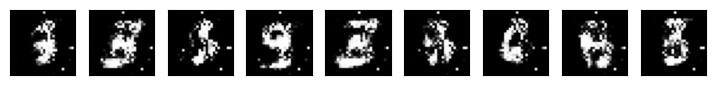

In [ ]:
#plot losses and generated images
noise = torch.tensor(draw_sample(9, zdim), dtype=torch.float32).to(device)
samples = G(noise)
# samples = get_n_samples(data_loader, 9)
fig = plt.figure(figsize=(10, 10))
gs = gridspec.GridSpec(10, 10)
for j, sample in enumerate(samples):
    sample = sample.detach().cpu().numpy()
    ax = plt.subplot(gs[j])
    ax.set_xticks([])
    ax.set_yticks([])
    plt.imshow(sample.reshape(28, 28), cmap='Greys_r')

plt.savefig('/content/res/{}.png'.format(str(j).zfill(7)), bbox_inches='tight')
plt.close()

## 2a. Implement GAN with Convolutional architecture.

Convolurional neural networks (CNNs) have a better feature representation, unlike, fully connected layers. Hence, it is required here to modify your code to include CNNs in your script. For more information, check out this [tutorial](https://gucifer.github.io/mediator/feature/2021/08/11/GAN-evaluation-using-FID-and-IS.html).

Similar to before, please report your training performance i.e. train loss as a figure and another figure containing a batch of generated images after training. You can plot one figure including and highlight the train loss using fully connected and CNN networks.

In [2]:
import torch
import torchvision
import numpy
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec


In [174]:
#load MNIST

data_transform = transforms.Compose(
    [
        transforms.Resize([32, 32]),
        transforms.ToTensor(),
        transforms.Normalize(0.5, 0.5),
    ]
)

params = dict(
  num_epochs = 20,
  batch_size = 64,
  learning_rate = 0.0002,
  momentum=1e-4,
  fashion_mnist = False
)

if params['fashion_mnist'] == False:
    dataset = datasets.MNIST('MNIST_data', train=True, download=True, transform=data_transform)
else:
    dataset = datasets.FashionMNIST('Fashion-MNIST_data', train=True, download=True, transform=data_transform)

data_loader = DataLoader(dataset, batch_size=params['batch_size'], shuffle=True)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [175]:
#setup convolutional generator
class CNN_Generator(nn.Module):
    def __init__(self, latent_dim, feature_maps=64, img_channels=1):
        super(CNN_Generator, self).__init__()
        self.model = nn.Sequential(
            # Input: latent_dim x 1 x 1
            nn.ConvTranspose2d(latent_dim, feature_maps * 4, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(feature_maps * 4),
            nn.ReLU(True),
            # State: (feature_maps * 4) x 4 x 4

            nn.ConvTranspose2d(feature_maps * 4, feature_maps * 2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(feature_maps * 2),
            nn.ReLU(True),
            # State: (feature_maps * 2) x 8 x 8

            nn.ConvTranspose2d(feature_maps * 2, feature_maps, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(feature_maps),
            nn.ReLU(True),
            # State: feature_maps x 16 x 16

            nn.ConvTranspose2d(feature_maps, img_channels, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()
            # Output: img_channels x 28 x 28
    )

    def forward(self, x):
        x = self.model(x)
        return x

In [176]:
latent_dim = 100
gen = CNN_Generator(latent_dim)
example_img = data_loader.dataset[0][0] # single image from a dataset
noise = torch.randn(1, latent_dim, 1, 1, device=device) # generating a single latent vecotr for testing
generated_noise = gen(noise)

In [177]:
#setup convolutional discriminator
class CNN_Discriminator(nn.Module):
    def __init__(self, latent_dim, feature_maps=64, img_channels=1):
        super(CNN_Discriminator, self).__init__()
        self.latent_dim = latent_dim
        self.feature_maps = feature_maps
        self.img_channels = img_channels

        self.model = nn.Sequential(
            nn.Conv2d(self.img_channels, self.feature_maps, 4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(self.feature_maps, self.feature_maps * 2, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(self.feature_maps * 2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(self.feature_maps * 2, self.feature_maps * 4, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(feature_maps * 4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(self.feature_maps * 4, self.latent_dim, 4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(latent_dim),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(self.latent_dim, 1, 1, stride=1, padding=0, bias=False),
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # print("parameters shape", self.latent_dim, self.feature_maps, self.img_channels)
        # print("input shape", x.shape)
        logits = self.model(x)
        res = self.sigmoid(logits)
        return logits, res

In [178]:
disc = CNN_Discriminator(latent_dim)
duplicated_tensor = generated_noise.repeat(2, 1, 1, 1) # duplicate the tensor to make it (2, 100, 1, 1) so it can run through the discriminator
log, result = disc(duplicated_tensor)
print(log.shape)

torch.Size([2, 1, 1, 1])


In [182]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

total_params = count_parameters(gen)
print(f"Total trainable (generator) parameters: {total_params}")
total_params = count_parameters(disc)
print(f"Total trainable (discriminator) parameters: {total_params}")

Total trainable (generator) parameters: 1066880
Total trainable (discriminator) parameters: 1067052


In [179]:
# create a sample
def draw_sample(sample_shape):
    return np.random.uniform(-1.0, 1.0, size=sample_shape).astype(np.float32)

In [180]:
#training loop
# x = torch.tensor(draw_sample(1, 784), dtype=torch.float32).to(device)
# z = torch.tensor(draw_sample(1, zdim), dtype=torch.float32).to(device)

G = CNN_Generator(latent_dim).to(device)
D = CNN_Discriminator(latent_dim).to(device)

# G_sample_train = G(z)
# D_logit_real, D_real = D(x)
# D_logit_gen, D_fake = D(G_sample_train.detach())
# G_sample_inf = G(z)

criterion = nn.BCEWithLogitsLoss()

# D_loss_real = criterion(D_logit_real, torch.ones_like(D_logit_real))
# D_loss_gen = criterion(D_logit_gen, torch.zeros_like(D_logit_gen))
# D_loss = D_loss_real + D_loss_gen

# G_loss = criterion(D_logit_gen, torch.ones_like(D_logit_gen))

opt_g = optim.Adam(G.parameters(), lr=0.0002, betas=(0.8, 0.999))
opt_d = optim.Adam(D.parameters(), lr=0.0001, betas=(0.9, 0.999))

In [181]:
#training loop

for epoch in range(params['num_epochs']):
    for batch_idx, (real_imgs, _) in enumerate(data_loader):
        # Update discriminator
        z = torch.tensor(draw_sample((params['batch_size'], latent_dim, 1, 1))).to(device)

        opt_d.zero_grad()

        G_sample_train = G(z)
        # print(real_imgs.shape)
        D_logit_real, D_real = D(real_imgs)
        D_logit_gen, D_fake = D(G_sample_train.detach())

        D_loss_real = criterion(D_logit_real, torch.ones_like(D_logit_real))
        D_loss_gen = criterion(D_logit_gen, torch.zeros_like(D_logit_gen))
        D_loss = D_loss_real + D_loss_gen

        D_loss.backward()
        nn.utils.clip_grad_norm_(D.parameters(), max_norm=1.0)  # Gradient clipping
        opt_d.step()

        # Update generator
        # z = torch.tensor(draw_sample(params['batch_size'], zdim)).to(device)
        opt_g.zero_grad()

        # G_sample_train = G(z)
        D_logit_gen, D_fake = D(G_sample_train)

        G_loss = criterion(D_logit_gen, torch.ones_like(D_logit_gen))

        G_loss.backward()
        nn.utils.clip_grad_norm_(G.parameters(), max_norm=1.0)  # Gradient clipping
        opt_g.step()

    # if epoch % 20 == 0:
    print(f'Epoch [{epoch}/{params["num_epochs"]}], D_loss: {D_loss.item():.4f}, G_loss: {G_loss.item():.4f}, D_loss_real: {D_loss_real.item():.4f}, D_loss_gen: {D_loss_gen.item():.4f}, Total loss: {G_loss.item() + D_loss.item():.4f}, ratio: {G_loss.item() / D_loss.item():.4f}')

KeyboardInterrupt: 

In [ ]:
#plot losses and generated images with the convolutional GAN

## 2b. now reimplement this with FASHION-MNIST with a convolutinal architecture

## 3. Conditional GAN (cGAN)

Vanilla GANs produce synthetic images by drawing a random vector from latent space. However, we may condition the GAN to additional information, namely, a class label e.g. label  "0" in MNIST. This requires to additionally input the label to G and D networks along with random vector drawn from latent space. You may use this [cGAN](https://learnopencv.com/conditional-gan-cgan-in-pytorch-and-tensorflow/) tutorial to implement a cGAN based on the convolutional archiecture you've implemented before. Furthermore, MNIST should be used in this task.

In [ ]:
#generator and discriminator

In [ ]:
#define training step for generator

#define training step for discriminator

In [ ]:
#training loop


In [ ]:
#plot looses and generated images along wth their conditions